In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [35]:
# Load dataset
file_path = "../../data/ethusd_group_project.csv"
df = pd.read_csv(file_path, parse_dates=['time'])

# Ensure time is sorted
df = df.sort_values(by="time")

# Set time as index
df.set_index('time', inplace=True)

In [36]:
df.head(2)

,open,close,high,low,volume,"RV_d,t",daily_return,"RV_w,t","RV_m,t","ln_RV_d,t",...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
time,,,,,,,,,,,,,,,,,,,,,
2016-03-09,11.197,11.197,11.197,10.660,41.139523,0.014515,NaN,NaN,NaN,-4.232581,...,97.74,96.832,22.36,25.7,20.27,91.0,298976.54,732221.29,3141.9415,15.6595
2016-03-10,11.072,11.750,11.850,11.072,1.030000,0.003658,0.049388,NaN,NaN,-5.610725,...,97.74,96.832,22.36,25.7,20.27,91.0,298976.54,732221.29,3141.9415,15.6595


In [37]:
df.tail(2)

,open,close,high,low,volume,"RV_d,t",daily_return,"RV_w,t","RV_m,t","ln_RV_d,t",...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
time,,,,,,,,,,,,,,,,,,,,,
2023-10-07,1645.5,1634.5,1647.9,1630.5,953.564307,0.000047,-0.006806,0.000688,0.000363,-9.962319,...,119.846,124.332,29.97,34.67,26.65,63.8,513250.88,916401.9,5038.9871,19.0462
2023-10-08,1634.5,1626.5,1641.2,1625.9,646.669448,0.000027,-0.004894,0.000342,0.000358,-10.506913,...,119.846,124.332,29.97,34.67,26.65,63.8,513250.88,916401.9,5038.9871,19.0462


### Train-Test Split

In [38]:
# Train-Test Split (80% train, 10% validation, 10% test)
# (daily_return would be the input for GARCH models)
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

train_size = int(0.8 * len(df))
r_train, r_test = df.log_return[:train_size], df.log_return[train_size:]
RV_train, RV_test = df['RV_d,t'][:train_size], df['RV_d,t'][train_size:]

# Reserve one part of training data for validation
valid_size = int(len(r_train) * 0.2)  # 20% of training data
r_val, RV_val = r_train[-valid_size:], RV_train[-valid_size:]
r_train, RV_train = r_train[:-valid_size], RV_train[:-valid_size]

# Drop NaN values
r_train.dropna(inplace=True)
train_size = len(r_train)

print("Training Set:", r_train.shape, RV_train.shape)
print("Validation Set:", r_val.shape, RV_val.shape)
print("Test Set:", r_test.shape, RV_test.shape)

Training Set: (1727,) (1728,)
Validation Set: (432,) (432,)
Test Set: (540,) (540,)


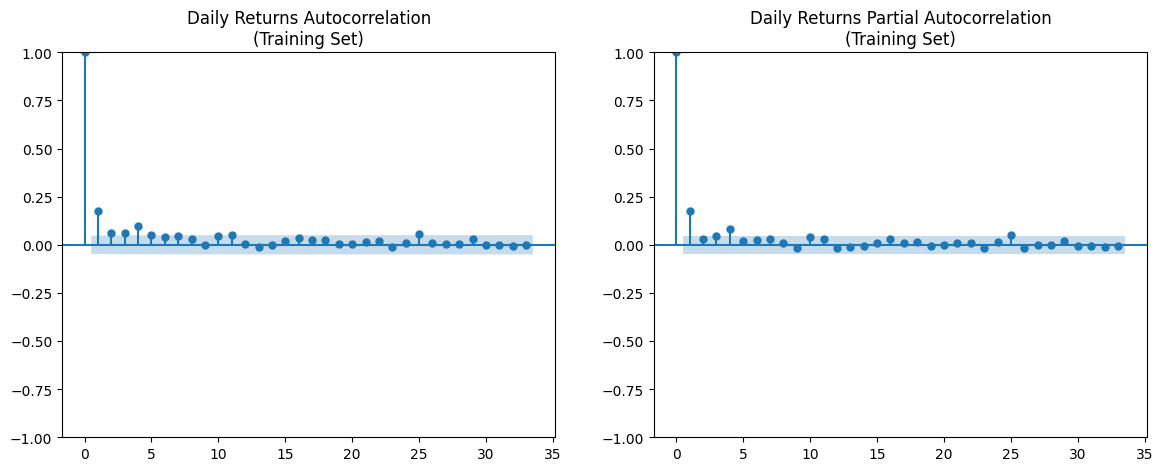

In [39]:
# Visualize the ACF and PACF of the returns
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(r_train**2, title='Daily Returns Autocorrelation\n(Training Set)', ax=ax[0])
plot_pacf(r_train**2, title='Daily Returns Partial Autocorrelation\n(Training Set)', ax=ax[1])
plt.show()

### Optimise p and q

In [40]:
# Store results
results = []

# Define range of p and q values to test
p_range = range(1, 10)
q_range = range(1, 10)

# Loop over all (p, q) combinations
for p in p_range:
    for q in q_range:
        predicted_volatility = []

        # Get the last conditional variance from training
        last_daily_returns = r_train[train_size-p-1:train_size-1]
        last_variances = df['RV_d,t'].iloc[train_size-q:train_size]
        
        try:
            model = arch_model(r_train, vol='Garch', p=p, q=q, rescale=False)
            garch_fit = model.fit(disp="off")
            params = garch_fit.params
            omega = params['omega']
            alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
            beta = [params[f'beta[{i+1}]'] for i in range(q)]

            # Compute volatility iteratively using GARCH equation
            for j in range(len(r_val)):
                r = r_val.iloc[j]
                RV = RV_val.iloc[j]               
                new_variance = omega
                for i in range(p):
                    new_variance += alpha[i] * (last_daily_returns.iloc[-(1+i)] ** 2)
                for i in range(q):
                    new_variance += beta[i] * last_variances.iloc[-(1+i)]
                predicted_volatility.append(new_variance)
                # Update for next step
                last_variances = last_variances.shift(-1)
                last_variances.iloc[-1] = RV
                last_daily_returns = last_daily_returns.shift(-1)
                last_daily_returns.iloc[-1] = r 

            # Compute MSE
            mse = mean_squared_error(RV_val, predicted_volatility)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(RV_val, predicted_volatility)
            r2 = r2_score(RV_val, predicted_volatility)
            results.append((p, q, mse, rmse, mape, r2))

        except Exception as e:
            print(f"Skipping GARCH({p},{q}) due to error: {e}")

/Users/ethan/Documents/GitHub/DSE4101-Group/env/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [41]:
# Convert results to a DataFrame
gm_results = pd.DataFrame(results, columns=['p', 'q', 'MSE', 'RMSE', 'MAPE', 'R2'])

In [42]:
gm_results

,p,q,MSE,RMSE,MAPE,R2
0,1,1,0.000025,0.005026,0.487641,0.004519
1,1,2,0.000022,0.004679,0.482768,0.136961
2,1,3,0.000022,0.004710,0.560463,0.125665
3,1,4,0.000022,0.004710,0.560461,0.125666
4,1,5,0.000022,0.004710,0.560461,0.125669
...,...,...,...,...,...,...
76,9,5,0.000020,0.004472,0.657792,0.211623
77,9,6,0.000020,0.004456,0.701588,0.217503
78,9,7,0.000020,0.004427,0.635872,0.227699
79,9,8,0.000020,0.004470,0.705325,0.212383


In [43]:
# Find the best (p, q) with the lowest MSE
best_params = gm_results.loc[gm_results['MSE'].idxmin()]
best_p = best_params['p']
best_q = best_params['q']
best_mse = best_params['MSE']
print(f"Best GARCH({best_p},{best_q}) model with MSE={best_mse:.6f}")

# Find the best (p, q) with the largest R2
best_params = gm_results.loc[gm_results['R2'].idxmax()]
best_p = best_params['p']
best_q = best_params['q']
best_r2 = best_params['R2']
print(f"Best GARCH({best_p},{best_q}) model with R2={best_r2:.6f}")

Best GARCH(4.0,3.0) model with MSE=0.000018
Best GARCH(4.0,3.0) model with R2=0.272353


### Best GARCH Model

In [44]:
p = 4
q = 3

In [ ]:
# Fit Best GARCH model to the training set
gm_best = arch_model(r_train, p=p, q=q, rescale=False)
gm_best_fit = gm_best.fit(disp='off')

#in-sample prediction

In [46]:
# Extract parameters
params = gm_best_fit.params
omega = params['omega']
alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
beta = [params[f'beta[{i+1}]'] for i in range(q)]
print(f"Estimated Parameters: \nomega={omega:.6f}, \nalpha={alpha}, \nbeta={beta}")

Estimated Parameters: 
omega=0.000547, 
alpha=[np.float64(0.10549417968736212), np.float64(0.038894309967779386), np.float64(0.03889459317302073), np.float64(0.1577853225124204)], 
beta=[np.float64(0.18150676787280456), np.float64(0.18150677926796674), np.float64(0.18150665149545353)]


In [47]:
# Get the last conditional variance from training
last_daily_returns = r_val[len(r_val)-p:len(r_val)]
last_variances = RV_val.iloc[len(RV_val)-q:len(RV_val)]

In [48]:
# Initialize list for storing predicted volatility (standard deviation)
predicted_volatility = []

# Compute forcase volatility on the test set
for j in range(len(r_test)):
    r = r_test.iloc[j]
    RV = RV_test.iloc[j]
    new_variance = omega
    for i in range(p):
        new_variance += alpha[i] * (last_daily_returns.iloc[-(1+i)] ** 2)
    for i in range(q):
        new_variance += beta[i] * last_variances.iloc[-(1+i)]
    predicted_volatility.append(new_variance)
    # Update for next step
    last_variances = last_variances.shift(-1)
    last_variances.iloc[-1] = RV
    last_daily_returns = last_daily_returns.shift(-1)
    last_daily_returns.iloc[-1] = r 

In [49]:
# Calculate Error Metrics
mse = mean_squared_error(RV_test, predicted_volatility)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(RV_test, predicted_volatility)
r2 = r2_score(RV_test, predicted_volatility)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"R² Score: {r2:.6f}")

Mean Squared Error (MSE): 0.000004
Root Mean Squared Error (RMSE): 0.001959
Mean Absolute Percentage Error (MAPE): 232.597090%
R² Score: 0.287130


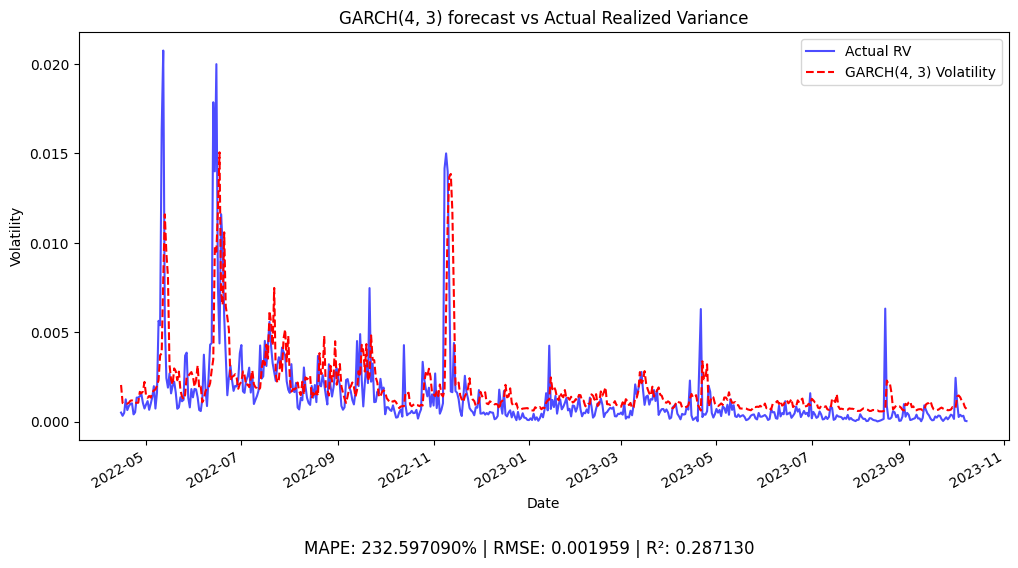

In [50]:
# Create a DataFrame for visualization
df_pred = pd.DataFrame({'Predicted Volatility': predicted_volatility}, index=r_test.index)

# Plot the predicted volatility against the realized volatility on the test set
plt.figure(figsize=(12, 6))
RV_test.plot(label='Actual RV', color="blue", alpha=0.7)
df_pred['Predicted Volatility'].plot(label=f'GARCH({p}, {q}) Volatility', color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"GARCH({p}, {q}) forecast vs Actual Realized Variance")
plt.legend()
#add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/GARCH({p}, {q})_plot.png')
plt.show()

# Save the results to a CSV file
df_pred.to_csv('../../results/models/GARCH_predictions.csv')